# Notes

## note 1
committee on original sample -> measure entropy in each instance -> newly labeled original sample -> train on that newly labeled original sample


On original sample, we didn’t use gradient yet, and we have entropy on the original sample. -> extract information based on the entropy of original sample.
Not all points in ambient space is interested.


Having adversarial attack is having more information about gradient. -> we can get more datapoints in the ambient space which we’re interested in.
Some of those we experience increased entropy even though human doesn’t recognize that perturbation. -> perturbation provides nice, bigger dataset with ‘finer’ label under the entropy measurement.

agree on original sample -> transition map is well defined.
after attack, disagree (C1 perturbed region) -> epsilon-differentiable transition map comes up? May not be relevant.


entropy != 0 -> dangerous sign

## note 2
For making new labels before adversarial attack, the main difficulty is that the training accuracy of each model is close to 100%; so for training data, the entropy is close to zero and there would be just very few new labels for training data. So it won't work in this way before attack.

So the new-label method for training only works after adversarial attacks. We may regard adversarial attack as the fastest way to produce entropy and hence new labels.

## therefore..

1. Construct a committee. We prefer to have members with diversity. However, our models are all ResNet structure with different number of parameters. Let us choose randomly four committee members in each type of ResNet.

2. Prepare for two type of adversarial attacks: PGD(big perturbation) and CWL2(small perturbation). 
**PGD and CWL2 are generated by ResNet56v1 model - 0 ** therefore we can have two types of committee, one is without ResNet56v1_0 and the other is with that.

3. Measure entropy at all points. Keep track if committee agree on that original version of sample just for case.

4. Label it accordingly, such as entropy $=0 \to $ original label and $>0 \to $ label by adding $10$

In [1]:
# load necessary libraries
import os, glob
import numpy as np
import tensorflow as tf
import pandas as pd
import keras
from keras.models import load_model
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import Model
from scipy.stats import entropy
import math
# load all models from the specified folder
# assuming the models are saved in Keras format with '.keras' extension
# Say 'B-type' model, where 'B' stands for 'Base'.
folder = 'CIFAR10models/ResNet/'
pattern = os.path.join(folder, '*cifar10*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models= {os.path.basename(f): load_model(f) for f in file_list}


# load additional models from another folder
# assuming these models are also saved in Keras format with '.keras' extension
# Say 'SB-type', where 'SB' stands for 'Specialized Base'.
folder = 'CIFAR10models/more_tunned/'
pattern = os.path.join(folder, '*_more_specialized*.keras')
file_list = sorted(glob.glob(pattern))
loaded_models.update({os.path.basename(f): load_model(f) for f in file_list})

label_dict = {(3,1) : 'ResNet20v1',
        (3,2) : 'ResNet20v2',
        (9,1): 'ResNet56v1',
        (9,2): 'ResNet56v2'}

(x, y), (x_test, y_test) = cifar10.load_data()
x_train, x_v, y_train, y_v = train_test_split(x, y, test_size=0.2, 
                                              random_state=42) # random state has been always 42.
x_train = x_train.astype('float32') / 255.0
x_val = x_v.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_categorical_10 = to_categorical(y_train,10)
y_val_categorical_10 = to_categorical(y_v,10)
y_test_categorical_10 = to_categorical(y_test,10)
y_test_categorical_20 = to_categorical(y_test,20)


### Compose committee

In [2]:
# Set the predetermined random seed
rng = np.random.default_rng(seed=42)

# Define ranges
range1 = [range(8), range(4), range(4), range(4)]
range2 = [range(8), range(4), [0], range(4)]

# Sample one tuple from each
tuple1 = tuple(rng.choice(r) for r in range1)
tuple2 = tuple(rng.choice(r) for r in range2)

print("Comm 1:", tuple1)
print("Comm 2:", tuple2)

comm_B_1 = []
comm_B_2 = []
comm_SB_1 = []
comm_SB_2 = []
for file_name, model in loaded_models.items():
    # Extract model name from the file name
    base = file_name.replace('.keras','')
    parts = base.split('_')
    if parts[0] == 'n':
        model_name = label_dict[(int(parts[1]),int(parts[2][-1]))] + '_B_'+parts[-1][-1]
    else:
        model_name = parts[0] + '_SB_' + parts[-1]
    # print(f"Model: {model_name}")
    parts = model_name.split('_')
    if parts[0] == 'ResNet20v1':
        if parts[1] == 'B':
            if int(parts[-1]) == tuple1[0]:
                comm_B_1.append((model_name,model))
            if int(parts[-1]) == tuple2[0]:
                comm_B_2.append((model_name,model))
        elif parts[1] == 'SB':
            if int(parts[-1]) == tuple1[0]:
                comm_SB_1.append((model_name,model))
            if int(parts[-1]) == tuple2[0]:
                comm_SB_2.append((model_name,model))
    if parts[0] == 'ResNet20v2':
        if parts[1] == 'B':
            if int(parts[-1]) == tuple1[1]:
                comm_B_1.append((model_name,model))
            if int(parts[-1]) == tuple2[1]:
                comm_B_2.append((model_name,model))
        elif parts[1] == 'SB':
            if int(parts[-1]) == tuple1[1]:
                comm_SB_1.append((model_name,model))
            if int(parts[-1]) == tuple2[1]:
                comm_SB_2.append((model_name,model))
    if parts[0] == 'ResNet56v1':
        if parts[1] == 'B':
            if int(parts[-1]) == tuple1[2]:
                comm_B_1.append((model_name,model))
            if int(parts[-1]) == tuple2[2]:
                comm_B_2.append((model_name,model))
        elif parts[1] == 'SB':
            if int(parts[-1]) == tuple1[2]:
                comm_SB_1.append((model_name,model))
            if int(parts[-1]) == tuple2[2]:
                comm_SB_2.append((model_name,model))
    if parts[0] == 'ResNet56v2':
        if parts[1] == 'B':
            if int(parts[-1]) == tuple1[3]:
                comm_B_1.append((model_name,model))
            if int(parts[-1]) == tuple2[3]:
                comm_B_2.append((model_name,model))
        elif parts[1] == 'SB':
            if int(parts[-1]) == tuple1[3]:
                comm_SB_1.append((model_name,model))
            if int(parts[-1]) == tuple2[3]:
                comm_SB_2.append((model_name,model))

Comm 1: (0, 3, 2, 1)
Comm 2: (3, 3, 0, 0)


### Load training/validation adv samples

In [3]:
# As SB model shows better performance on the certain part, let use SB type models to analyze the behavior on the certain part against adversarial examples.

# Load the adversarial examples

## set all files.
## Possibly there is no merged testing dataset, or validation dataset.
## We only look for testing dataset.
import re

pattern1 = re.compile(r'_\d+to\d+_')
pattern2 = re.compile(r'test')

folder = './adversarial_examples/gen_by_ResNet'
all_files = os.listdir(folder)

filtered_files = [
    fname for fname in all_files
    if fname.endswith('.npy') and not pattern1.search(fname) and not pattern2.search(fname)
]


## load all the training and validation dataset

loaded_training_dataset = {}
loaded_validation_dataset = {}
import re
for f in filtered_files:
    
    base = f.replace('.keras.npy','').replace('.npy','')
    parts = base.split('_')
    '''
    cwl2_x_tr_untargeted
    cwl2_x_v_untargeted.npy
    pgd_0.376_x_target_to_ll.npy
    pgd_0.376_x_target_to_second.npy
    pgd_0.376_x_untarget.npy
    pgd_0.376_x_val_target_to_ll.npy
    pgd_0.376_x_val_target_to_second.npy
    pgd_0.376_x_val_untarget.npy
    '''
    
    attack_type = parts[0]
    if attack_type == 'cwl2':
        direction = 'untargeted'
        if parts[2] == 'tr':
            train_or_val = 'train'
        else:
            train_or_val = 'val'
    else:
        attack_type = 'PGD by ResNet56v1'
        direction = parts[-1]
        if direction == 'll':
            direction = 'targeted to least'
        elif direction =='second':
            direction = 'targeted to 2nd'
        else:
            direction = 'untargeted'
        if parts[3] == 'val':
            train_or_val = 'val'
        else:
            train_or_val = 'train'
    key = (attack_type, direction, train_or_val)
    if train_or_val == 'train':
        loaded_training_dataset[key] = np.load(os.path.join(folder, f))
    else:
        loaded_validation_dataset[key] = np.load(os.path.join(folder, f))

## including dataset generated by VGG

folder = './adversarial_examples/gen_by_VGG'
all_files = os.listdir(folder)

filtered_files = [
    fname for fname in all_files
    if fname.endswith('.npy') and not pattern2.search(fname)
]
for f in filtered_files:
    base = f.replace('.npy','')
    parts = base.split('_')
    
    '''
    pgd_0.376_x_target_to_ll.npy
    pgd_0.376_x_untarget.npy
    pgd_0.376_x_val_target_to_ll.npy
    pgd_0.376_x_val_untarget.npy
    '''
    if parts[-1] == 'll':
        direction = 'targeted to least'
    else:
        direction = 'untargeted'
    if parts[3] == 'val':
        train_or_val = 'val'
    else:
        train_or_val = 'train'
    key = ('PGD by VGG', direction, train_or_val)
    if train_or_val == 'train':
        loaded_training_dataset[key] = np.load(os.path.join(folder, f))
    else:
        loaded_validation_dataset[key] = np.load(os.path.join(folder, f))

print('-'*50, 'keys for adv samples', '-'*50)
for k in loaded_training_dataset.keys():
    print(k)
    
for k in loaded_validation_dataset.keys():
    print(k)

-------------------------------------------------- keys for adv samples --------------------------------------------------
('cwl2', 'untargeted', 'train')
('PGD by ResNet56v1', 'untargeted', 'train')
('PGD by ResNet56v1', 'targeted to 2nd', 'train')
('PGD by ResNet56v1', 'targeted to least', 'train')
('PGD by VGG', 'untargeted', 'train')
('PGD by VGG', 'targeted to least', 'train')
('PGD by ResNet56v1', 'targeted to least', 'val')
('cwl2', 'untargeted', 'val')
('PGD by ResNet56v1', 'targeted to 2nd', 'val')
('PGD by ResNet56v1', 'untargeted', 'val')
('PGD by VGG', 'targeted to least', 'val')
('PGD by VGG', 'untargeted', 'val')


### function: get entropy array

In [4]:
def get_entropy_array(committee : list[tuple[str,Model]], sample : np.ndarray): 
    '''
    param committee: list of tuple (member, model)
    param sample: numpy array of (n,) shape
    
    return tuple of dict, numpy array of (n,) shape
    dictionary : committee member -> list of [answer to the sample, certainty to the sample]
    '''
    comm_pred = {}
    for member, model in committee:
        p = model.predict(sample,verbose = 0)
        comm_pred[member] = [
                                np.argmax(p,axis=-1),
                                np.max(p,axis=-1)
                                ]
    stacked = np.stack([member_pred[0] for member_pred in comm_pred.values()], axis=1)
    counts = np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=1, arr=stacked)
    probs = counts / counts.sum(axis=1, keepdims=True)
    disagreements = entropy(probs, axis=1, base = 10)
    
    return disagreements

In [5]:
# for key, sample in loaded_training_dataset.items():
#     name = key[0]+'_'+key[1]+'_'+key[2]
#     print(name)
#     for committee_name, committee in committees.items():
#         print(f'Committee: {committee_name}')
        
#         entropy_array = get_entropy_array(committee, sample)
#         np.save(f'./entropies/entropy_{committee_name}_{name}.npy', entropy_array)

# for key, sample in loaded_validation_dataset.items():
#     name = key[0]+'_'+key[1]+'_'+key[2]
#     print(name)
#     for committee_name, committee in committees.items():
#         print(f'Committee: {committee_name}')
        
#         entropy_array = get_entropy_array(committee, sample)
#         np.save(f'./entropies/entropy_{committee_name}_{name}.npy', entropy_array)

### Let us focus on SB1 committee on CWL2 train/val and PGD train/val.

In [7]:
committee = comm_SB_1

## CWL2 train and val
cwl2_train = loaded_training_dataset[('cwl2', 'untargeted', 'train')]
cwl2_val = loaded_validation_dataset[('cwl2', 'untargeted', 'val')]
entropy_cwl2_train = np.load('./entropies/entropy_SB1_cwl2_untargeted_train.npy')
entropy_cwl2_val = np.load('./entropies/entropy_SB1_cwl2_untargeted_val.npy')

## PGD untargeted train and val
PGD_train = loaded_training_dataset[('PGD by ResNet56v1', 'untargeted', 'train')]
PGD_val = loaded_validation_dataset[('PGD by ResNet56v1', 'untargeted', 'val')]
entropy_PGD_untargeted_train = np.load('./entropies/entropy_SB1_PGD by ResNet56v1_untargeted_train.npy')
entropy_PGD_untargeted_val = np.load('./entropies/entropy_SB1_PGD by ResNet56v1_untargeted_val.npy')

## PGD targeted train and val
PGD_targeted_train = loaded_training_dataset[('PGD by ResNet56v1', 'targeted to least', 'train')]
PGD_targeted_val = loaded_validation_dataset[('PGD by ResNet56v1', 'targeted to least', 'val')]
entropy_PGD_targeted_train = np.load('./entropies/entropy_SB1_PGD by ResNet56v1_targeted to least_train.npy')
entropy_PGD_targeted_val = np.load('./entropies/entropy_SB1_PGD by ResNet56v1_targeted to least_val.npy')



Currently we compose committee with four members, therefore possible entropies are 0, ~0.24, ~0.3, ~0.45, ~0.6 and 1. 

In [ ]:
def make_new_label(y_sample :np.ndarray, 
                   entropy_array : np.ndarray, 
                   entropy_thresholds : list[float] | float = 0.4, 
                   num_classes : int = 10):
    size = entropy_array.shape[0]
    y_sample_copy = y_sample.copy()[:size]
    new_label_cnt = 1
    if isinstance(entropy_thresholds,float):
        mask = entropy_array > entropy_thresholds
        y_sample_copy[mask] = y_sample_copy[mask]+num_classes*new_label_cnt
        return y_sample_copy, new_label_cnt
    elif len(entropy_thresholds) == 1:
        mask = entropy_array > entropy_thresholds[0]
        y_sample_copy[mask] = y_sample_copy[mask]+num_classes*new_label_cnt
        return y_sample_copy, new_label_cnt
    else:
        prev_th = entropy_thresholds[0]
        for curr_th in entropy_thresholds[1:]:
            mask = np.prod([entropy_array>prev_th,entropy_array<=curr_th],
                     axis=0)==1
            y_sample_copy[mask] = y_sample_copy[mask]+num_classes*new_label_cnt
            new_label_cnt += 1
        return y_sample_copy, new_label_cnt

In [9]:
def committee_answers(committee, sample, entropy, mask = None):
    if mask is None:
        # Create a mask for non-zero entropy values
        mask = entropy_PGD_untargeted_train != 0

    # Prepare data for the table
    table_data = {
        'Original Label': y_train[:sample.shape[0]][mask].reshape(-1),
        'Entropy': np.round(entropy[mask], 3)
    }

    # Loop through the committee to get predictions
    for member, model in committee:
        # Predictions on CWL2 adversarial data
        p  = model.predict(sample[mask], verbose=0)
        table_data[f'{member[-1]}p'] = np.argmax(p , axis=-1)
        table_data[f'{member[-1]}c'] = np.round(np.max(p , axis=-1), 3)

    # Create and display the DataFrame
    df = pd.DataFrame(table_data)
    return df


In [47]:
## Save newly labeled adversarial samples


## CWL2 untargeted 
np.save('./new_labels/SB1/new_label_cwl2_untargeted_train.npy',
       make_new_label(y_train, entropy_cwl2_train)[0]
        )
np.save('./new_labels/SB1/new_label_cwl2_untargeted_val.npy',
       make_new_label(y_v, entropy_cwl2_val)[0]
        )
# test dataset
entropy_array = get_entropy_array(committee,np.load('./adversarial_examples/gen_by_ResNet/cwl2_x_test_untargeted.npy'))
np.save('./new_labels/SB1/new_label_cwl2_untargeted_test.npy',
       make_new_label(y_test, entropy_array)[0]
        )


## PGD untargeted
np.save('./new_labels/SB1/new_label_PGD_untargeted_train.npy',
        make_new_label(y_train, entropy_PGD_untargeted_train)[0])
np.save('./new_labels/SB1/new_label_PGD_untargeted_val.npy',
       make_new_label(y_v, entropy_PGD_untargeted_val)[0]
        )
# test dataset
entropy_array = get_entropy_array(committee,np.load('./adversarial_examples/gen_by_ResNet/pgd_0.376_x_test_untarget_gen_by_n_9_v1_cifar10.keras.npy'))
np.save('./new_labels/SB1/new_label_PGD_untargeted_test.npy',
       make_new_label(y_test, entropy_array)[0]
        )

## PGD targeted
np.save('./new_labels/SB1/new_label_PGD_targeted_train.npy',
       make_new_label(y_train, entropy_PGD_targeted_train)[0]
        )
np.save('./new_labels/SB1/new_label_PGD_targeted_val.npy',
       make_new_label(y_v, entropy_PGD_targeted_val)[0]
        )
# test dataset
entropy_array = get_entropy_array(committee,np.load('./adversarial_examples/gen_by_ResNet/pgd_0.376_x_test_target_to_ll_gen_by_n_9_v1_cifar10.keras.npy'))
np.save('./new_labels/SB1/new_label_PGD_targeted_test.npy',
       make_new_label(y_test, entropy_array)[0]
        )


In [ ]:
## custom turn specialist function
from keras import layers
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 5, 10, 15, 18 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 18:
        lr *= 0.5e-3
    elif epoch > 15:
        lr *= 1e-3
    elif epoch > 10:
        lr *= 1e-2
    elif epoch > 5:
        lr *= 1e-1
#     print('Learning rate: ', lr)
    return lr

def turn_specialist(model : Model, path : str,
        x_tr: np.ndarray | None = None,
        y_tr: np.ndarray | None = None,
        x_v: np.ndarray | None = None,
        y_v: np.ndarray | None = None,
        num_classes : int = 10,
        epochs: int = 21,
        learning_rate : float = 1e-3,
        batch_size: int = 128,
        # save_each: bool = False,
        # save_bests: int | None = None,
        verbose: int = 1,
        name : str = ''
    ):
        
        # build specialist network
        base = Model(inputs = model.inputs, outputs = model.layers[-2].output, name=f"base{name}")
        x    = keras.Input(shape=base.input_shape[1:], name=f"in{name}")
        y    = Dense(num_classes, name=f"dense{name}")(base(x)) # 10 can be changed to len(newtarget)
        z    = layers.Softmax(name=f"softmax{name}")(y)
        specialist = Model(inputs = x, outputs = z)
        specialist.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        




        # callbacks
        callbacks = [ModelCheckpoint(path, monitor="val_accuracy",
                                    save_best_only=True, verbose=verbose)]
        
        callbacks += [LearningRateScheduler(lr_schedule),
                        ReduceLROnPlateau(factor=np.sqrt(0.1), patience=5, min_lr=5e-7)]

        # fit 
        hist = specialist.fit(x_tr, y_tr, batch_size=batch_size,
                        validation_data=(x_v, y_v),
                        epochs=epochs, callbacks=callbacks, verbose=verbose)



        # ---------- summary ----------
        metric = "val_accuracy"
        best = np.max(hist.history[metric])
        first = hist.history[metric][0]
        print(f"best {metric} {best:.3f} (first {first:.3f})")
        return specialist, hist


In [14]:
new_label_up_to = 20

In [28]:
new_label_train

array([6], dtype=uint8)

Training specialist for ResNet20v1_SB_0...
best val_accuracy 0.843 (first 0.753)


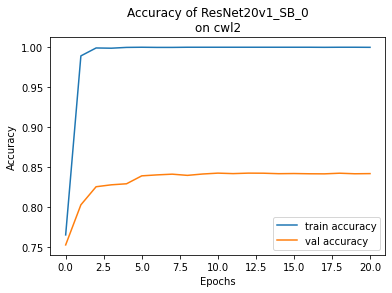

best val_accuracy 0.827 (first 0.695)


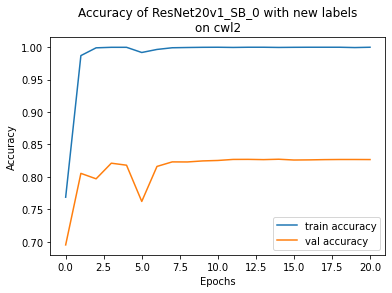

Training specialist for ResNet20v2_SB_3...
best val_accuracy 0.861 (first 0.752)


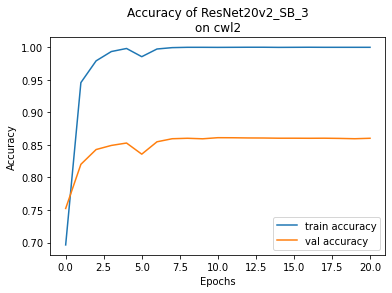

best val_accuracy 0.828 (first 0.700)


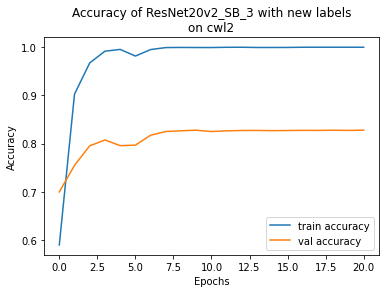

Training specialist for ResNet56v1_SB_2...
best val_accuracy 0.866 (first 0.816)


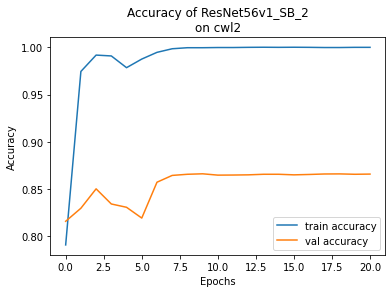

best val_accuracy 0.845 (first 0.722)


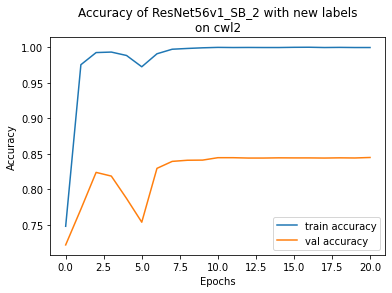

Training specialist for ResNet56v2_SB_1...
best val_accuracy 0.873 (first 0.623)


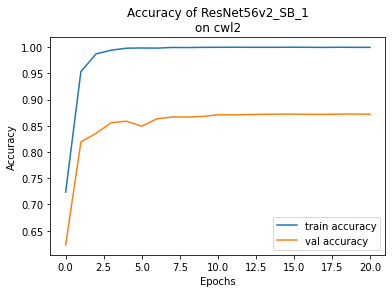

best val_accuracy 0.843 (first 0.667)


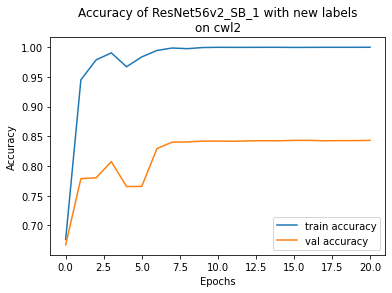

Training specialist for ResNet20v1_SB_0...
best val_accuracy 0.832 (first 0.763)


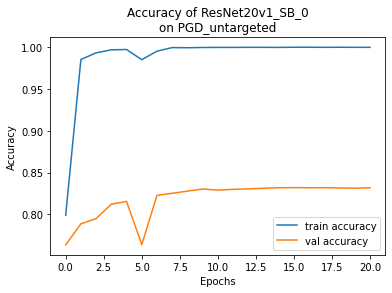

best val_accuracy 0.750 (first 0.604)


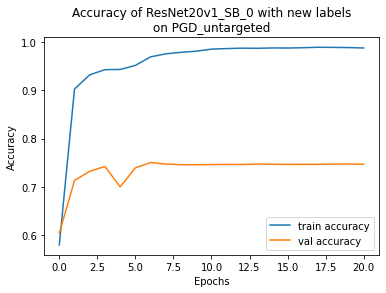

Training specialist for ResNet20v2_SB_3...
best val_accuracy 0.843 (first 0.752)


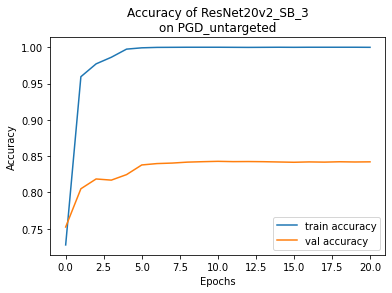

best val_accuracy 0.757 (first 0.680)


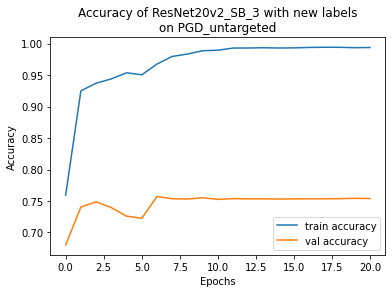

Training specialist for ResNet56v1_SB_2...
best val_accuracy 0.851 (first 0.748)


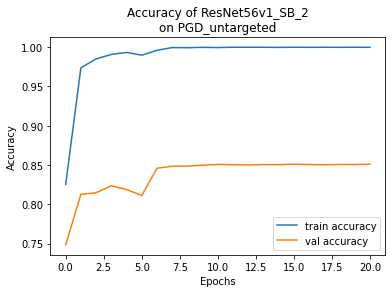

best val_accuracy 0.767 (first 0.710)


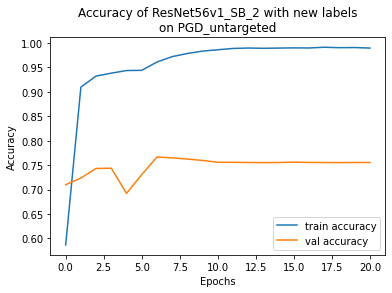

Training specialist for ResNet56v2_SB_1...
best val_accuracy 0.853 (first 0.754)


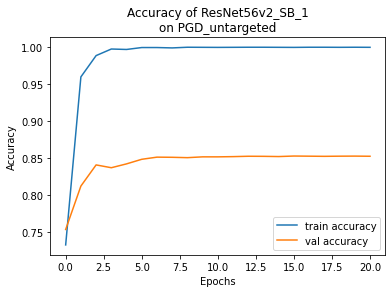

best val_accuracy 0.763 (first 0.588)


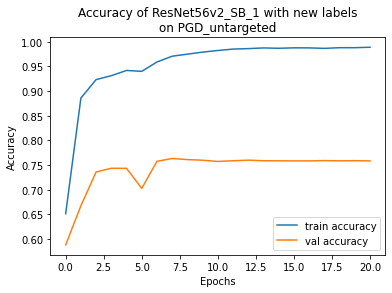

Training specialist for ResNet20v1_SB_0...
best val_accuracy 0.831 (first 0.699)


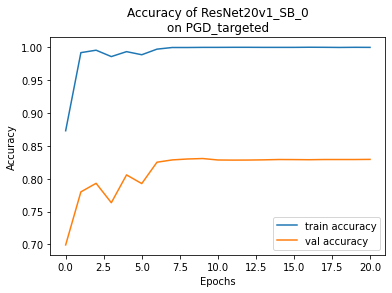

best val_accuracy 0.715 (first 0.580)


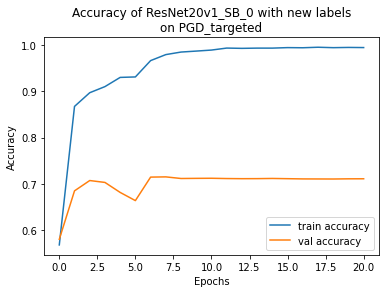

Training specialist for ResNet20v2_SB_3...
best val_accuracy 0.830 (first 0.766)


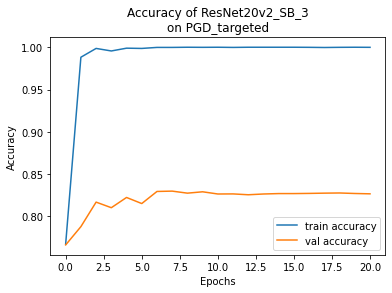

best val_accuracy 0.710 (first 0.578)


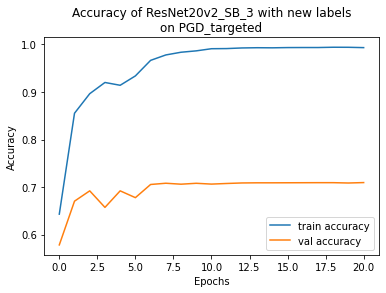

Training specialist for ResNet56v1_SB_2...
best val_accuracy 0.846 (first 0.782)


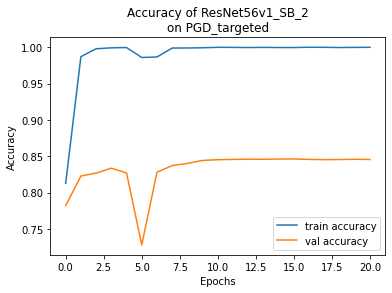

best val_accuracy 0.722 (first 0.655)


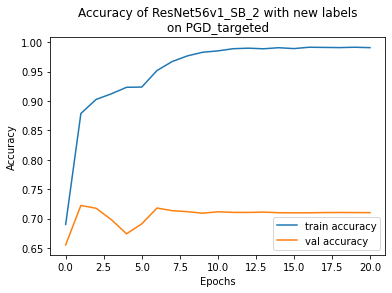

Training specialist for ResNet56v2_SB_1...
best val_accuracy 0.849 (first 0.725)


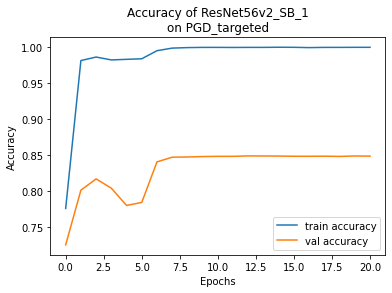

best val_accuracy 0.726 (first 0.652)


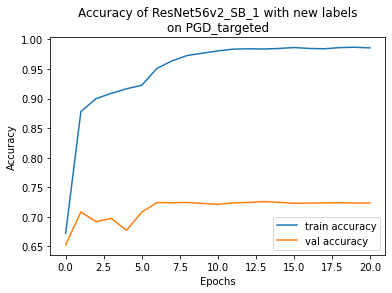

In [48]:
for adv_name in ['cwl2', 'PGD_untargeted', 'PGD_targeted']:
    if adv_name == 'cwl2':
        key_tr = ('cwl2', 'untargeted', 'train')
        key_v = ('cwl2', 'untargeted', 'val')
        

    elif adv_name == 'PGD untargeted':
        key_tr = ('PGD by ResNet56v1', 'untargeted', 'train')
        key_v = ('PGD by ResNet56v1', 'untargeted', 'val')
        
    elif adv_name == 'PGD targeted':
        key_tr = ('PGD by ResNet56v1', 'targeted to least', 'train')
        key_v = ('PGD by ResNet56v1', 'targeted to least', 'val')
    
    adv_tr = loaded_training_dataset[key_tr]
    adv_v = loaded_validation_dataset[key_v]
    for member, model in comm_SB_1:
        print(f"Training specialist for {member}...")
        # baseline, which is specialize once with the original labels.
        specialist, history = turn_specialist(model,
                        path=f'./new_labels/specialists/SB1/specialist_{member}_{adv_name}_baseline.keras',
                        x_tr = adv_tr,
                        y_tr = to_categorical(y_train[:adv_tr.shape[0]], 10),
                        x_v = adv_v,
                        y_v = to_categorical(y_v, 10),
                                              name = 'one_more',
                                              verbose = 0
                        )
        # see the graph of training process
        import matplotlib.pyplot as plt
        plt.plot(history.history['accuracy'], label='train accuracy')
        plt.plot(history.history['val_accuracy'], label='val accuracy')
        plt.title(f'Accuracy of {member}\non {adv_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # load the new labels
        if adv_name == 'cwl2':
            new_label_train = np.load(f'./new_labels/SB1/new_label_cwl2_untargeted_train.npy')
            new_label_val = np.load(f'./new_labels/SB1/new_label_cwl2_untargeted_val.npy')
        else:
            new_label_train = np.load(f'./new_labels/SB1/new_label_{adv_name}_train.npy')
            new_label_val = np.load(f'./new_labels/SB1/new_label_{adv_name}_val.npy')
        
        # Specialization with the new labels.
        specialist, history = turn_specialist(model,
                        path=f'./new_labels/specialists/SB1/specialist_{member}_{adv_name}_new_label.keras',
                        x_tr = adv_tr,
                        y_tr = to_categorical(new_label_train[:adv_tr.shape[0]], new_label_up_to),
                        x_v = adv_v,
                        y_v = to_categorical(new_label_val, new_label_up_to),
                                              num_classes = new_label_up_to,
                                              name = 'one_more_new_label',
                                              verbose = 0
                        )
        # see the graph of training process
        plt.plot(history.history['accuracy'], label='train accuracy')
        plt.plot(history.history['val_accuracy'], label='val accuracy')
        plt.title(f'Accuracy of {member} with new labels\non {adv_name}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # save the specialist model
        specialist.save(f'./new_labels/specialists/SB1/specialist_{member}_{adv_name}_new_label.keras')
    